In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (make_scorer,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             recall_score,
                             precision_score,
                             precision_recall_curve,
                             classification_report,
                             plot_confusion_matrix,
                             plot_roc_curve)
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 36

In [2]:
test = pd.read_csv('../data/notebook_produced_4/test.csv')

test.head()

,euribor3m,nr_employed,emp_var_rate,contact_cellular,cons_price_idx,cons_conf_idx,pdays,day_of_week_mon,day_of_week_wed,day_of_week_thu,...,job_blue-collar,job_admin.,education_high.school,education_university.degree,poutcome_failure,education_basic,job_technician,marital_divorced,default_no,y
0,4.857,5191.0,1.1,0,0.93994,-36.4,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,4.857,5191.0,1.1,0,0.93994,-36.4,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,4.857,5191.0,1.1,0,0.93994,-36.4,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,4.857,5191.0,1.1,0,0.93994,-36.4,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
4,4.857,5191.0,1.1,0,0.93994,-36.4,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0


In [3]:
X = test.drop(columns='y')
y = test.y

## read in trained model

In [4]:
rand_forest = joblib.load('../saved_models/rand_forest_trees_20_depth_20.joblib')

y_predict = rand_forest.predict(X)
y_proba = rand_forest.predict_proba(X)[:,1]

print('AUC Score:', roc_auc_score(y, y_proba))

AUC Score: 0.736420552948626


In [5]:
print('Holdout Classification Report\n')
print(classification_report(y, y_predict))

Holdout Classification Report

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     10964
           1       0.33      0.45      0.38      1392

    accuracy                           0.84     12356
   macro avg       0.63      0.67      0.64     12356
weighted avg       0.86      0.84      0.85     12356



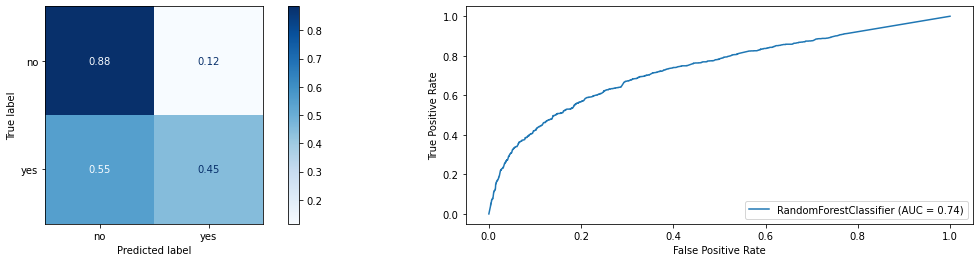

In [6]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,4))
plot_confusion_matrix(rand_forest,
                      X, y,
                      display_labels=['no', 'yes'],
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax1
                     )
plot_roc_curve(rand_forest, X, y, ax=ax2);

# Let's look at Lift

In [7]:
def tp_tn_fn_fp(true_value, predicted_value):
    tp, tn, fn, fp = 0, 0, 0, 0
    for v, p in zip(true_value, predicted_value):
        if v == p:
            if v+p == 2: tp += 1
            else: tn += 1
        elif v == 1: fn += 1
        else: fp += 1
    return tp, tn, fn, fp

def lift_score(true_value, predicted_value):
    tp, tn, fn, fp = tp_tn_fn_fp(true_value, predicted_value)
    return ( tp/(tp+fp) ) / ( (tp+fn) / (tp+tn+fp+fn) )

print('Lift for all holdout data:', lift_score(y, y_predict))

Lift for all holdout data: 2.93222673811086


In [8]:
c_name = ['target', 'probability', 'prediction']

tpp = np.column_stack((y.to_numpy(), y_proba, y_predict))
tpp = pd.DataFrame(tpp, columns=c_name)

tpp.shape

(12356, 3)

In [9]:
def computeLift(res, arr, r):
    population = res.target.value_counts()
    population_ratio = population.loc[1.0]/population.sum()

    l = []
    for i in arr:
        d = res.loc[res.probability >= i,:]
        sample = d.target.value_counts()
        sample_ratio = sample.loc[1.0]/sample.sum()
        l.append([round(i, ndigits=r), sample_ratio/population_ratio, f'Y:{sample.loc[1.0]}, N:{sample.loc[0.0]}'])
    above_prob = pd.DataFrame(l, columns=['above_probability', 'lift', 'count'])
    return above_prob

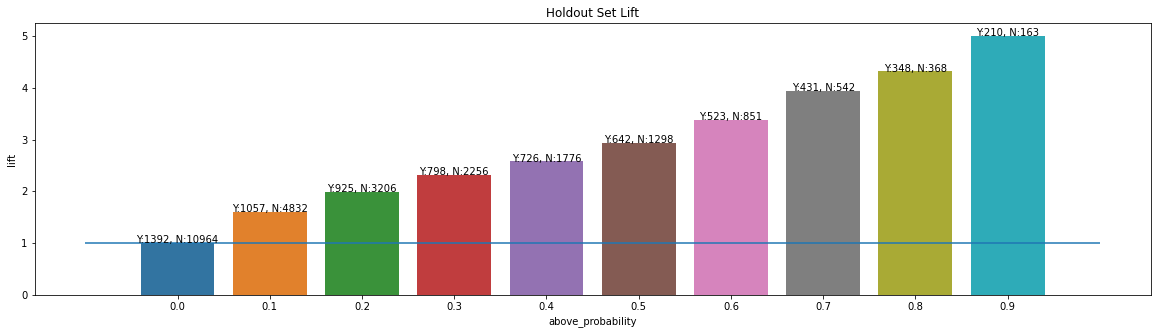

In [10]:
thresholds = np.arange(0, 1, .1)
round_prob = 1
lift = computeLift(tpp, thresholds, round_prob)

f, ax1 = plt.subplots(figsize=(20, 5))

sns.barplot(data=lift, x='above_probability', y='lift', ax=ax1)
for row in lift.itertuples():
    ax1.text(row.Index, row.lift, row.count, color='black', ha="center")
ax1.hlines(1, -1,10)
ax1.set_title('Holdout Set Lift');

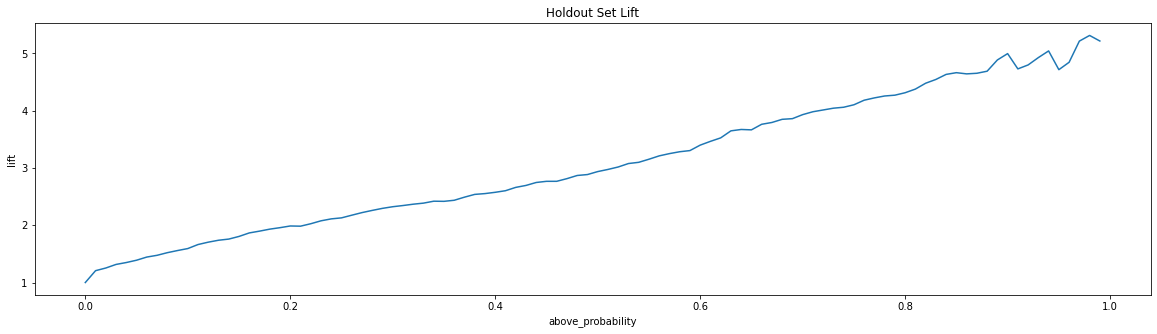

In [11]:
thresholds = np.arange(0, 1, .01)
round_prob = 2
lift = computeLift(tpp, thresholds, round_prob)

f, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=lift, x='above_probability', y='lift', ax=ax)
ax.set_title('Holdout Set Lift');

# Profit curves

In [12]:
cost_per_call = 5
yes_profit = 35 - cost_per_call

func = lambda p: p*yes_profit - (1-p)*cost_per_call

tpp['expected_value'] = tpp.probability.apply(func)
tpp['actual_value'] = tpp.target.apply(func)

In [13]:
print('For Profit of > $0.00, target customers above this probablility:', tpp.loc[tpp.expected_value>0, 'probability'].min()*100)
print('For Profit of > $5.00, target customers above this probablility:', tpp.loc[tpp.expected_value>5, 'probability'].min()*100)
print('For Profit of > $10.00, target customers above this probablility:', tpp.loc[tpp.expected_value>10, 'probability'].min()*100)

For Profit of > $0.00, target customers above this probablility: 14.333333333333334
For Profit of > $5.00, target customers above this probablility: 28.59523809523809
For Profit of > $10.00, target customers above this probablility: 42.95253357753358


In [14]:
def computeProfitCurve(res, arr, r):
    l = []
    for i in arr:
        exp, act = res.loc[res.probability >= i, ['expected_value', 'actual_value']].sum()
        l.append([round(i, ndigits=r), exp, act])
    above_prob = pd.DataFrame(l, columns=['above_probability', 'expected_profit', 'actual_profit'])
    return above_prob

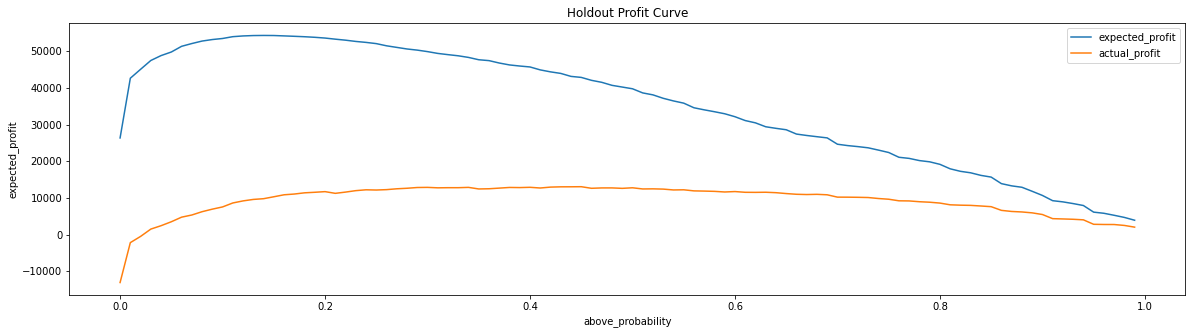

In [15]:
thresholds = np.arange(0, 1, .01)
round_prob = 2
profit = computeProfitCurve(tpp, thresholds, round_prob)

f, ax1 = plt.subplots(figsize=(20,5))
sns.lineplot(data=profit, x='above_probability', y='expected_profit', ax=ax1)
sns.lineplot(data=profit, x='above_probability', y='actual_profit', ax=ax1)
ax1.legend(['expected_profit', 'actual_profit'])
ax1.set_title('Holdout Profit Curve');